In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#### Matrix Factorization using Gradient Descent

The idea behind Matrix Factorization is that there can be some latent/hidden factors that express every user and every movie. As far as accuracy of model is concerned, we are not interested in knowing these factors however iterpretability/explainability of these hidden factors becomes an issue. 

The number of latent factors are also going to be small since there can be only a few factors that are common to users and movies.

So we factorize the user-movie ratings matrix $R$ as a product of two matrices $P$ and $Q$. Since we are only considering a few factors, the reconstructed matrix $R^{'}$ will be different from $R$ and our objective is to minimize the difference between two. 

We do that by minimizing Forbenius norm of error: 

\begin{aligned}
\epsilon = R-R^{'}
\end{aligned}

In [2]:
# preprocessing movies data
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')

In [3]:
# preprocessing ratings data
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

In [4]:
# splitting data into train and validation set 
ratings_df, ratings_val = train_test_split(ratings_df, test_size=0.1, random_state=42)
ratings_df.shape, ratings_val.shape

((900188, 4), (100021, 4))

In [5]:
def get_users_movies(df):
    users_list = df['userID'].unique().tolist()
    movies_list = df['movieID'].unique().tolist()
    n_users = len(users_list)
    n_movies = len(movies_list)
    
    print('Number of Users:', n_users) 
    print('Number of Movies:', n_movies)
    return users_list, movies_list, n_users, n_movies

def get_sample(df, users_list, movies_list, sample_user_pct, sample_movie_pct):
    n_users_sample = int(sample_user_pct * len(users_list))
    n_movies_sample = int(sample_movie_pct * len(movies_list))

    np.random.shuffle(users_list)
    np.random.shuffle(movies_list)

    sample_users = users_list[:n_users_sample]
    sample_movies = movies_list[:n_movies_sample]

    df = df[df.userID.isin(sample_users)]
    df = df[df.movieID.isin(sample_movies)]
    df = df.reset_index(drop=True)
    return df

In [6]:
users_list, movies_list, n_users, n_movies = get_users_movies(ratings_df)

sample_user_pct = 0.1
sample_movie_pct = 0.1
ratings_df = get_sample(ratings_df, users_list, movies_list, sample_user_pct, sample_movie_pct)
print('\nSample: ')
users_list, movies_list, n_users, n_movies = get_users_movies(ratings_df)

Number of Users: 6040
Number of Movies: 3694

Sample: 
Number of Users: 594
Number of Movies: 344


In [7]:
# relabelling userIDs
userID2idx = dict(zip(users_list, range(n_users)))
idx2userID = {v:k for k, v in userID2idx.items()}
ratings_df['userID'].replace(userID2idx, inplace=True)

# relabelling movieIDs
movieID2idx = dict(zip(movies_list, range(n_movies)))
idx2movieID = {v:k for k, v in movieID2idx.items()}
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))
ratings_df['movieID'].replace(movieID2idx, inplace=True)

In [8]:
def get_ratings_mat(ratings_df):
    # mapping users to their rated movies
    interaction_dict = dict(ratings_df.groupby('userID')['movieID'].apply(lambda x: np.array(x)))
    # mapping users to their ratings
    ratings_dict = dict(ratings_df.groupby('userID')['rating'].apply(lambda x: np.array(x)))
    ratings_mat = np.zeros((n_users, n_movies), dtype='int')
    for userID, movieIDs in interaction_dict.items():        
        # highlight rating
        ratings_mat[userID-1, movieIDs] = ratings_dict[userID]
    return ratings_mat

In [9]:
R = get_ratings_mat(ratings_df)
assert R.shape == (n_users, n_movies)

n_latent = 50
P_init = np.random.normal(size=(n_users, n_latent))
Q_init = np.random.normal(size=(n_latent, n_movies))

#### Governing Equations

\begin{aligned}
\left\|R-R^{\prime}\right\|^{2} &=\operatorname{tr}\left(\left(R-R^{\prime}\right)\left(R-R^{\prime}\right)^{\top}\right) \\
\left\|R-R^{\prime}\right\|^{2} &=\operatorname{tr}\left(R R^{\top}-R R^{\prime T}-R^{\prime} R^{\top}+R^{\prime} R^{\prime T}\right) \\
\end{aligned}

#### Cost Function:
\begin{aligned}
J =& \operatorname{tr}\left(R R^{\top}\right)-\operatorname{tr}\left(R Q^{\top} P^{\top}\right)-\operatorname{tr}\left(P Q R^{\top}\right)+\operatorname{tr}\left(P Q Q^{T} P^ {T}\right) + \lambda(\operatorname{tr}\left(P P^{\top}\right) + \operatorname{tr}\left(Q Q^{\top}\right))
\end{aligned}

#### Gradient Equations:
\begin{aligned}
\partial{J}/\partial{P} &=-2 Q R^{\top}+2 Q Q^{\top} P^{\top} + 2\lambda P^{\top} \\
\partial{J}/\partial{Q} &=-2 R^{\top} P+2 Q^{\top} P^{\top} P+2 \lambda Q^{\top}
\end{aligned}

#### Matrix Calculus: 

\begin{aligned}
d \operatorname{tr}\left(R Q^{T} P^{\top}\right) &\left.=(d \operatorname{tr}\left(P Q R^{\top}\right)\right) \\
&=\operatorname{tr}\left(P d Q R^{\top}\right)= \operatorname{tr}((dP) Q R^{\top})\\
&=\operatorname{tr}\left(R^{\top} P d Q\right)=\operatorname{tr}\left(Q R^{\top} d P\right)
\end{aligned}

\begin{aligned}
&\frac{d \operatorname{tr}\left(R Q^{\top} P^{\top}\right)}{d Q}=R^{\top} P \\
&\frac{d \operatorname{tr}\left(R Q^{\top} P^{\top}\right)}{d P}=Q R^{\top}
\end{aligned}

Likewise, other equations can also be derived.

In [10]:
def loss_fn(R, P, Q, reg_coef):
    est_R = P @ Q
    return np.trace((R-est_R).T @ (R-est_R)) + reg_coef * (np.trace(P.T @ P) + np.trace(Q.T @ Q))

def gradient(R, P, Q, reg_coef):
    dP = -2 * Q @ R.T + 2 * Q @ Q.T @ P.T + 2 * reg_coef * P.T
    dQ = -2 * R.T @ P + 2 * Q.T @ P.T @ P + 2 * reg_coef * Q.T
    return dP.T, dQ.T

def gradient_descent(R, P_init, Q_init, alpha, eps, reg_coef, max_iters):
    P = P_init
    Q = Q_init
    dP = P_init
    dQ = Q_init
    
    n_iters = 0
    costs = []
    while np.linalg.norm(dP) > eps and np.linalg.norm(dQ) > eps:
        dP, dQ = gradient(R, P, Q, reg_coef)
        P = P - alpha * dP
        Q = Q - alpha * dQ

        cost = loss_fn(R, P, Q, reg_coef)
        costs.append(cost)
        n_iters +=1

        if n_iters % 500==0:
            print(f'Iteration: {n_iters} | Cost: {cost.round(3)}')
        if n_iters > max_iters:
            print(f'Terminated at {max_iters} iterations..')
            break
    return P, Q, costs

alpha = 1E-3
eps = 1E-2
reg_coef = 0.2
max_iters = 5000
P, Q, costs = gradient_descent(R, P_init, Q_init, alpha, eps, reg_coef, max_iters)

Iteration: 500 | Cost: 38513.427
Iteration: 1000 | Cost: 37894.851
Iteration: 1500 | Cost: 37732.239
Iteration: 2000 | Cost: 37653.217
Iteration: 2500 | Cost: 37613.026
Iteration: 3000 | Cost: 37596.935
Iteration: 3500 | Cost: 37590.405
Iteration: 4000 | Cost: 37587.468
Iteration: 4500 | Cost: 37585.968
Iteration: 5000 | Cost: 37585.04
Terminated at 5000 iterations..


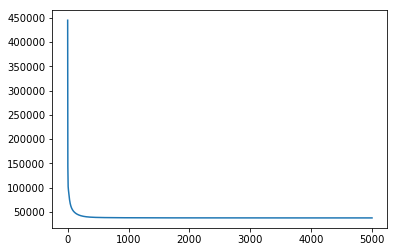

In [11]:
plt.plot(costs)
plt.show()

In [12]:
new_users_list = list(set(ratings_val['userID'].values) - set(users_list))
ratings_val = ratings_val[~ratings_val.userID.isin(new_users_list)]

new_movies_list = list(set(ratings_val['movieID'].values) - set(movies_list))
ratings_val = ratings_val[~ratings_val.movieID.isin(new_movies_list)].reset_index(drop=True)

ratings_val['userID'].replace(userID2idx, inplace=True)
ratings_val['movieID'].replace(movieID2idx, inplace=True)

In [13]:
def get_predictions(P, Q, ratings_val):
    preds = list(map(lambda x, y: P[x] @ Q[:, y], ratings_val.userID, ratings_val.movieID))
    return preds

def scale_predictions(preds, min_rating, max_rating):
    max_pred = max(preds)
    min_pred = min(preds)
    a = (max_rating - min_rating) / (max_pred - min_pred)
    b = (min_rating * max_pred - max_rating * min_pred) / (max_pred - min_pred)
    scaled_preds = list(map(lambda x: a*x + b, preds))
    return scaled_preds

We scale ratings linearly such that they lie in [1,5].

In [14]:
min_rating = 1
max_rating = 5

# true ratings
y_true = ratings_val.rating.values
# predicted ratings
preds = get_predictions(P, Q, ratings_val) 
# scaling ratings
y_pred = scale_predictions(preds, min_rating, max_rating)

In [15]:
mean_squared_error(y_true, y_pred)

3.5263273549961918